# EDA 4: Compilation

In [1]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
METRIC_NAME_MAP = {
    'precision': 'Precision@10',
    'recall': 'Recall@10',
    'ndcg': 'NDCG@10',
    'map': 'mAP',
    'mean_median_distance': 'Median distance',
    'gce_users': 'GCE for user fairness',
    'precision_active_users': 'Precision@10 (active users)',
    'precision_inactive_users': 'Precision@10 (inactive users)',
    'gce_items': 'GCE for item fairness',
    'exposure_short_head': 'Exposure count (short-head POIs)',
    'exposure_long_tail': 'Exposure count (long-tail POIs)',
}

dataset_sizes = {
        'Yelp': 7135,
        'Gowalla': 5628
    }

## 1. Exposure model

In [3]:
def load_dataset_exposure_model(model_name, dataset, exposure_model, provider_factor = 0):
    fairness = 'None'
    filename = f"../Outputs/{exposure_model}Fairness/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.csv"
    if provider_factor in [0.25, 0.75]:
        fairness = f'Provider_{exposure_model}Exposure_alpha' + str(provider_factor)
        filename = f"../Outputs/1_ExposureModelComparison/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.csv"
    elif provider_factor in [0.5, 1.0]:
        fairness = 'Provider' + str(provider_factor)
        filename = f"../Outputs/{exposure_model}Fairness/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.csv"

    return pd.read_csv(filename)

In [4]:
dataset_iter = product(
    ['USG', 'GeoSoCa', 'LORE'],
    ['Yelp', 'Gowalla'],
    ['PowerLaw', 'Linear', 'Logistic'],
    [0, 0.25, 0.5, 0.75, 1.0],
)

_dfs = []

for model_name, dataset, exposure_model, provider_factor in tqdm(dataset_iter, total=3*2*3*5):
    _df = load_dataset_exposure_model(model_name, dataset, exposure_model, provider_factor)
    _df['model'] = model_name
    _df['dataset'] = dataset
    _df['exposure_model'] = exposure_model
    _df['provider_coef'] = provider_factor
    _dfs.append(_df)

df = pd.concat(_dfs)

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 484.06it/s]


In [5]:
df.head()

,precision,recall,ndcg,map,mean_median_distance,gce_users,precision_active_users,precision_inactive_users,gce_items,exposure_short_head,exposure_long_tail,model,dataset,exposure_model,provider_coef
0,0.02968,0.04478,0.03981,0.01991,115.60542,-0.07079,0.05683,0.02290,-235.56310,22.53447,0.00773,USG,Yelp,PowerLaw,0.00
0,0.02995,0.04498,0.04019,0.02014,115.07955,-0.07236,0.05767,0.02302,-86.98926,22.47723,0.02087,USG,Yelp,PowerLaw,0.25
0,0.02914,0.04354,0.03945,0.01984,125.95407,-0.07489,0.05662,0.02227,-5.93957,21.04870,0.27914,USG,Yelp,PowerLaw,0.50
0,0.01521,0.02367,0.02629,0.01463,422.63194,-0.05637,0.02747,0.01214,-0.07314,7.36875,2.94184,USG,Yelp,PowerLaw,0.75
0,0.00362,0.00579,0.00615,0.00328,736.69097,-0.03202,0.00575,0.00308,-0.63292,0.40417,3.92878,USG,Yelp,PowerLaw,1.00


In [9]:
def display_exposure_model_impact(df, dataset, metrics):
    df_exposure_model = df[df.dataset == dataset] \
        [['model', 'exposure_model', 'provider_coef'] + metrics] \
        .melt(id_vars=['model', 'exposure_model', 'provider_coef']) \
        .rename(columns={'variable': 'metric'})
    return df_exposure_model.pivot(index=['model', 'exposure_model'], columns=['metric', 'provider_coef'], values=['value'])

def generate_latex_table(table):
    template = """
        \\begin{tabular}{|c c||c c c c c|c c c c c|}
            \hline
            Model & Exposure Model & \multicolumn{5}{c|}{Precision} & \multicolumn{5}{c|}{Long-tail Exposure} \\\\
            & & 0 & 0.25 & 0.50 & 0.75 & 1 & 0 & 0.25 & 0.50 & 0.75 & 1 \\\\
            \hline\hline
            """ + "\n".join([
                f"{model} & {exposure_model} & " + " & ".join((f"{x:.4f}" for x in scores)) + " \\\\"
                for (model, exposure_model), scores in table.iterrows()
            ]) + """
            \hline
        \\end{tabular}
    """
    return template

In [10]:
exposure_model_yelp = display_exposure_model_impact(df, 'Yelp', ['precision', 'exposure_long_tail'])
exposure_model_yelp

value                                      \
metric                 precision                                       
provider_coef               0.00     0.25     0.50     0.75     1.00   
model   exposure_model                                                 
GeoSoCa Linear           0.02252  0.01338  0.01173  0.01110  0.01071   
        Logistic         0.02252  0.01727  0.00889  0.00733  0.00730   
        PowerLaw         0.02252  0.01372  0.01086  0.00963  0.00813   
LORE    Linear           0.02300  0.01794  0.01470  0.01322  0.01240   
        Logistic         0.02300  0.01826  0.00956  0.00736  0.00719   
        PowerLaw         0.02300  0.01962  0.01364  0.01062  0.00819   
USG     Linear           0.02968  0.03139  0.02783  0.02282  0.01857   
        Logistic         0.02968  0.02961  0.02566  0.01228  0.00415   
        PowerLaw         0.02968  0.02995  0.02914  0.01521  0.00362   

                                                                               
metric                 exposure_long_tail                                      
provider_coef                        0.00     0.25     0.50     0.75     1.00  
model   exposure_model                                                         
GeoSoCa Linear                    1.70096  3.44671  4.15250  4.50262  4.68879  
        Logistic                  1.70096  3.06960  4.56932  4.69693  4.69701  
        PowerLaw                  1.70096  3.16362  3.52775  2.50246  1.84291  
LORE    Linear                    1.52896  2.79747  3.61411  4.13607  4.44260  
        Logistic                  1.52896  3.42165  4.81801  4.95029  4.95650  
        PowerLaw                  1.52896  2.22839  2.16467  1.88875  1.57681  
USG     Linear                    0.00773  0.03408  0.54242  1.82140  3.07653  
        Logistic                  0.00773  0.04608  1.15323  4.52268  5.68098  
        PowerLaw                  0.00773  0.02087  0.27914  2.94184  3.92878

In [11]:
exposure_model_gowalla = display_exposure_model_impact(df, 'Gowalla', ['precision', 'exposure_long_tail'])
exposure_model_gowalla

value                                      \
metric                 precision                                       
provider_coef               0.00     0.25     0.50     0.75     1.00   
model   exposure_model                                                 
GeoSoCa Linear           0.03811  0.02996  0.02871  0.02743  0.02660   
        Logistic         0.03811  0.03161  0.01823  0.01400  0.01324   
        PowerLaw         0.03811  0.02765  0.02422  0.02216  0.02027   
LORE    Linear           0.04824  0.04273  0.04051  0.03888  0.03779   
        Logistic         0.04824  0.02829  0.01491  0.01270  0.01247   
        PowerLaw         0.04824  0.03916  0.02601  0.01910  0.01564   
USG     Linear           0.05139  0.05043  0.04774  0.04460  0.04240   
        Logistic         0.05139  0.05004  0.03340  0.01949  0.01029   
        PowerLaw         0.05139  0.05249  0.04684  0.02930  0.01583   

                                                                               
metric                 exposure_long_tail                                      
provider_coef                        0.00     0.25     0.50     0.75     1.00  
model   exposure_model                                                         
GeoSoCa Linear                    0.79903  0.97964  1.07336  1.16259  1.24648  
        Logistic                  0.79903  1.21417  1.92628  2.03356  2.04591  
        PowerLaw                  0.79903  1.32312  1.80725  2.02073  2.06360  
LORE    Linear                    0.73538  0.93559  1.07575  1.19575  1.29611  
        Logistic                  0.73538  1.63259  2.04247  2.08146  2.08421  
        PowerLaw                  0.73538  1.29826  1.65275  1.77239  1.77709  
USG     Linear                    0.07664  0.10559  0.15668  0.25231  0.36891  
        Logistic                  0.07664  0.23190  1.43150  2.01903  2.26543  
        PowerLaw                  0.07664  0.15134  0.78765  1.65312  2.07887

**Takeaway**
* Linear wins

## 2. Provider Fairness Factor

(already been done, focus on others)

In [4]:
def load_dataset_provider_fairness(model_name, dataset, provider_factor = 0):
    dataset_sizes = {
        'Yelp': 7135,
        'Gowalla': 5628
    }

    fairness = 'None'
    if provider_factor > 0:
        fairness = 'Provider' + str(provider_factor)
    filename = f"../Outputs/LinearFairness/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.csv"

    return pd.read_csv(filename)

In [5]:
dataset_iter = product(
    ['USG', 'GeoSoCa', 'LORE'],
    ['Yelp', 'Gowalla'],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
)

_dfs = []

for model_name, dataset, provider_factor in tqdm(dataset_iter, total=3*2*11):
    _df = load_dataset_provider_fairness(model_name, dataset, provider_factor)
    _df['model'] = model_name
    _df['dataset'] = dataset
    _df['provider_coef'] = provider_factor
    _dfs.append(_df)

df2 = pd.concat(_dfs)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 442.60it/s]


In [161]:
def scatterplot_provider_factor(df):
    _df = df[['exposure_long_tail', 'exposure_short_head', 'model', 'dataset', 'provider_coef']] \
            .rename(columns={'provider_coef': 'Provider weight', 'model': 'Model'})

    plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(data=_df[_df['dataset'] == 'Yelp'], x='exposure_long_tail', y='exposure_short_head', style='Model', hue='Provider weight', ax=axs[0])
    axs[0].get_legend().remove()
    axs[0].set_xlabel('Long-tail')
    axs[0].set_ylabel('Short-head')
    axs[0].set_title(f'Exposure (Yelp)')
    axs[0].plot([0, 5, 10, 15, 20, 25], [0, 5, 10, 15, 20, 25])
    axs[0].set_xlim((-0.5, 10))
    axs[0].set_ylim((-0.5, 25))
    sns.scatterplot(data=_df[_df['dataset'] == 'Gowalla'], x='exposure_long_tail', y='exposure_short_head', style='Model', hue='Provider weight', ax=axs[1])
    # axs[1].get_legend().remove()
    axs[1].set_xlabel('Long-tail')
    axs[1].set_ylabel('Short-head')
    axs[1].set_title(f'Exposure (Gowalla)')
    axs[1].plot([0, 5, 10, 15, 20, 25], [0, 5, 10, 15, 20, 25])
    axs[1].set_xlim((-0.5, 4))
    axs[1].set_ylim((-0.5, 10))
    # axs[1].legend(bbox_to_anchor=(1.1, 1.05))
    axs[1].legend(bbox_to_anchor=(1.1, 0.4))

    fig.savefig(f"images_2/provider_fairness_plot.png", bbox_inches='tight')
    return fig, axs

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Exposure (Yelp)'}, xlabel='Long-tail', ylabel='Short-head'>,
        <Axes: title={'center': 'Exposure (Gowalla)'}, xlabel='Long-tail', ylabel='Short-head'>],
       dtype=object))

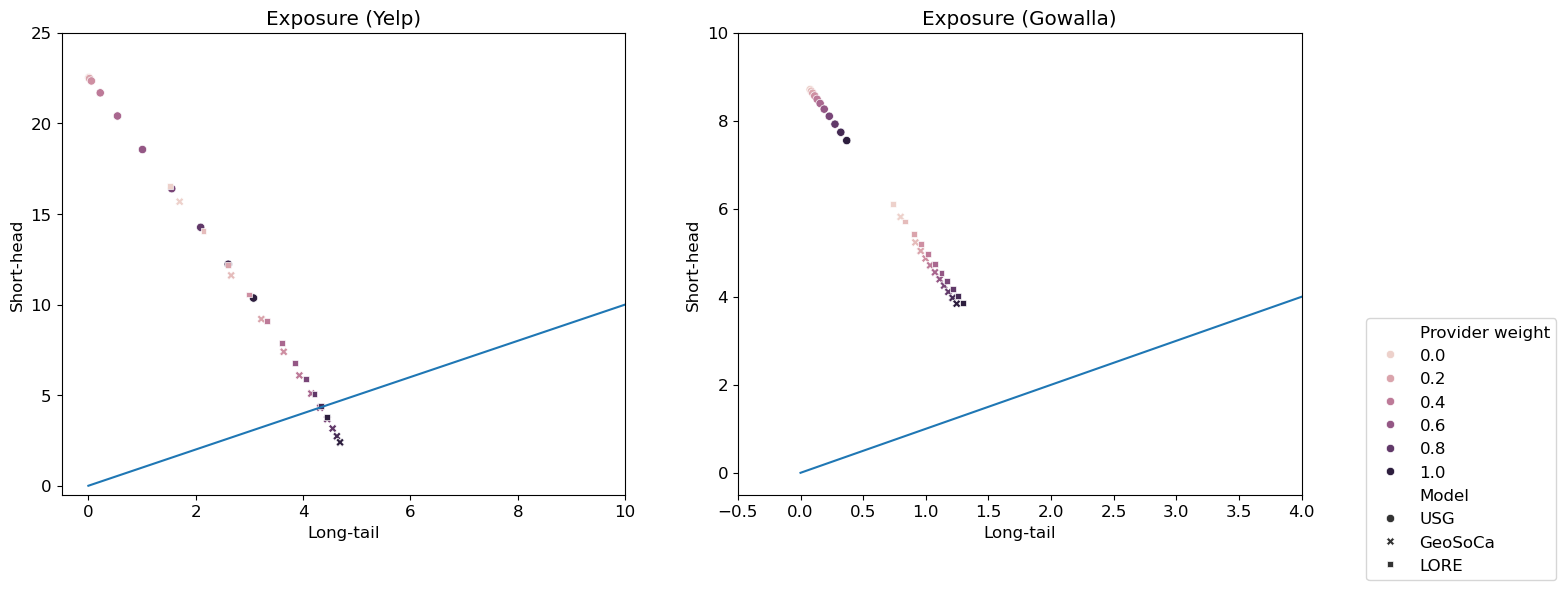

In [162]:
scatterplot_provider_factor(df2)

In [15]:
def plot_provider_factor(df, metric):
    _df = df[[metric, 'model', 'dataset', 'provider_coef']]
    metric_name = METRIC_NAME_MAP[metric]

    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.lineplot(data=_df[_df['dataset'] == 'Yelp'], x='provider_coef', y=metric, hue='model', marker='D', markersize=10.0, ax=axs[0])
    axs[0].legend()
    axs[0].set_xlabel('Provider factor coefficient')
    axs[0].set_ylabel(metric_name)
    axs[0].set_title(f'{metric_name} (Yelp)')
    sns.lineplot(data=_df[_df['dataset'] == 'Gowalla'], x='provider_coef', y=metric, hue='model', marker='D', markersize=10.0, ax=axs[1])
    axs[1].legend()
    axs[1].set_xlabel('Provider factor coefficient')
    axs[1].set_ylabel(metric_name)
    axs[1].set_title(f'{metric_name} (Gowalla)')

    fig.savefig(f"images_2/{metric}_vs_provider_alpha.png", bbox_inches='tight')
    return fig, axs

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Precision@10 (Yelp)'}, xlabel='Provider factor coefficient', ylabel='Precision@10'>,
        <Axes: title={'center': 'Precision@10 (Gowalla)'}, xlabel='Provider factor coefficient', ylabel='Precision@10'>],
       dtype=object))

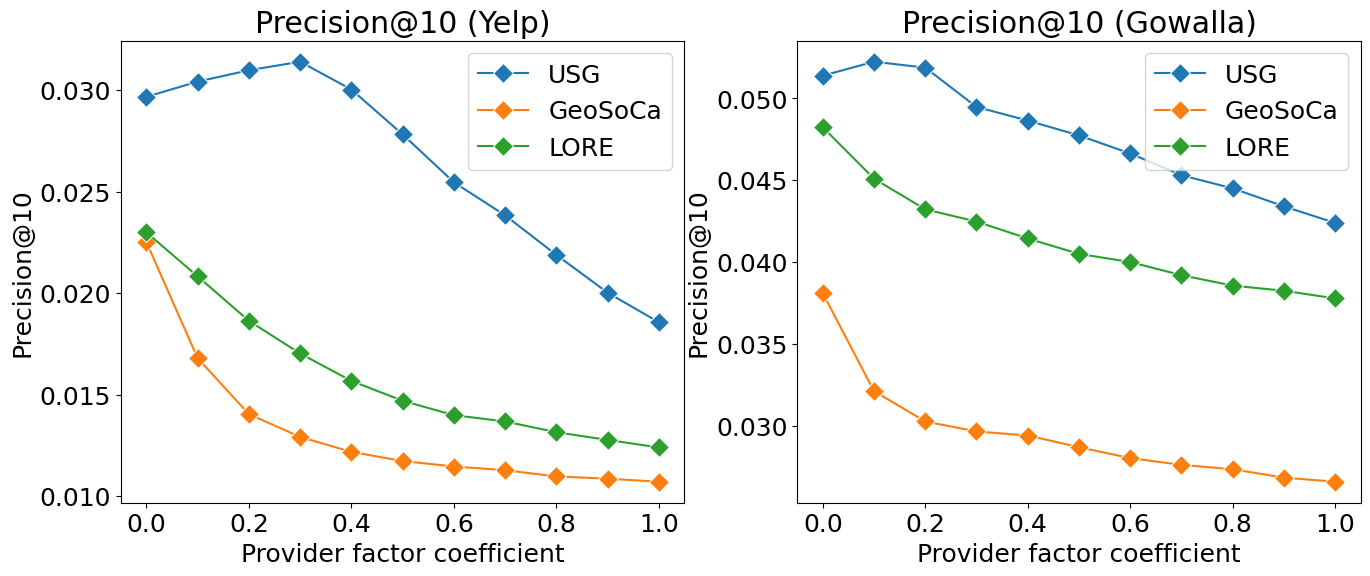

In [16]:
plot_provider_factor(df2, 'precision')

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Exposure count (long-tail POIs) (Yelp)'}, xlabel='Provider factor coefficient', ylabel='Exposure count (long-tail POIs)'>,
        <Axes: title={'center': 'Exposure count (long-tail POIs) (Gowalla)'}, xlabel='Provider factor coefficient', ylabel='Exposure count (long-tail POIs)'>],
       dtype=object))

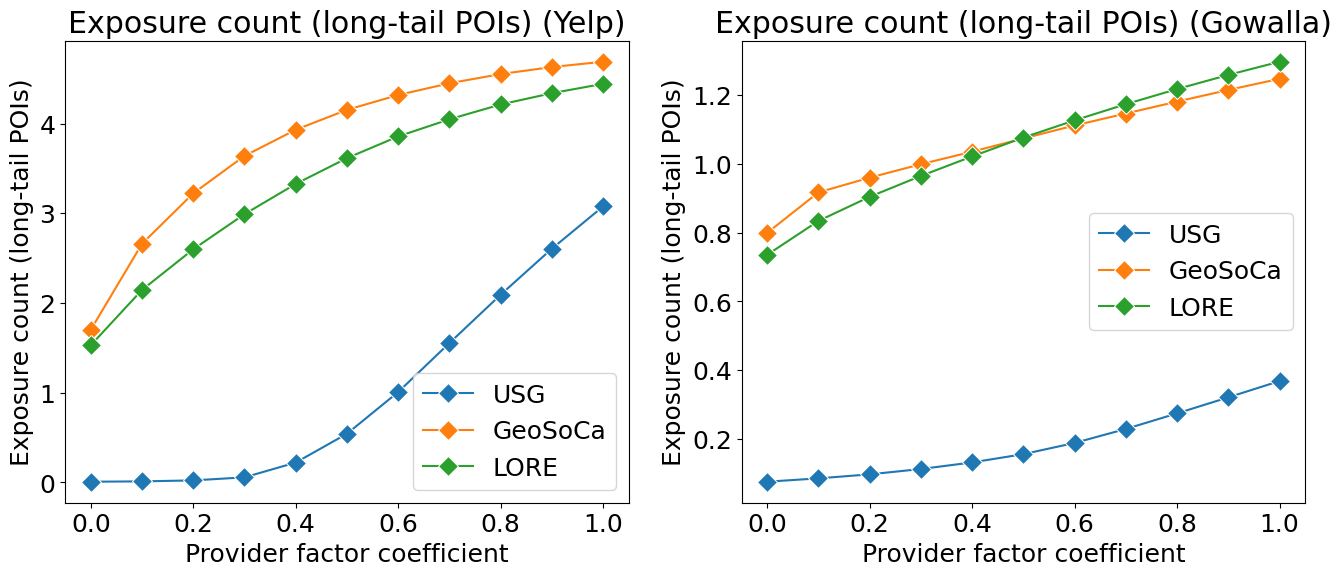

In [17]:
plot_provider_factor(df2, 'exposure_long_tail')

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Exposure count (short-head POIs) (Yelp)'}, xlabel='Provider factor coefficient', ylabel='Exposure count (short-head POIs)'>,
        <Axes: title={'center': 'Exposure count (short-head POIs) (Gowalla)'}, xlabel='Provider factor coefficient', ylabel='Exposure count (short-head POIs)'>],
       dtype=object))

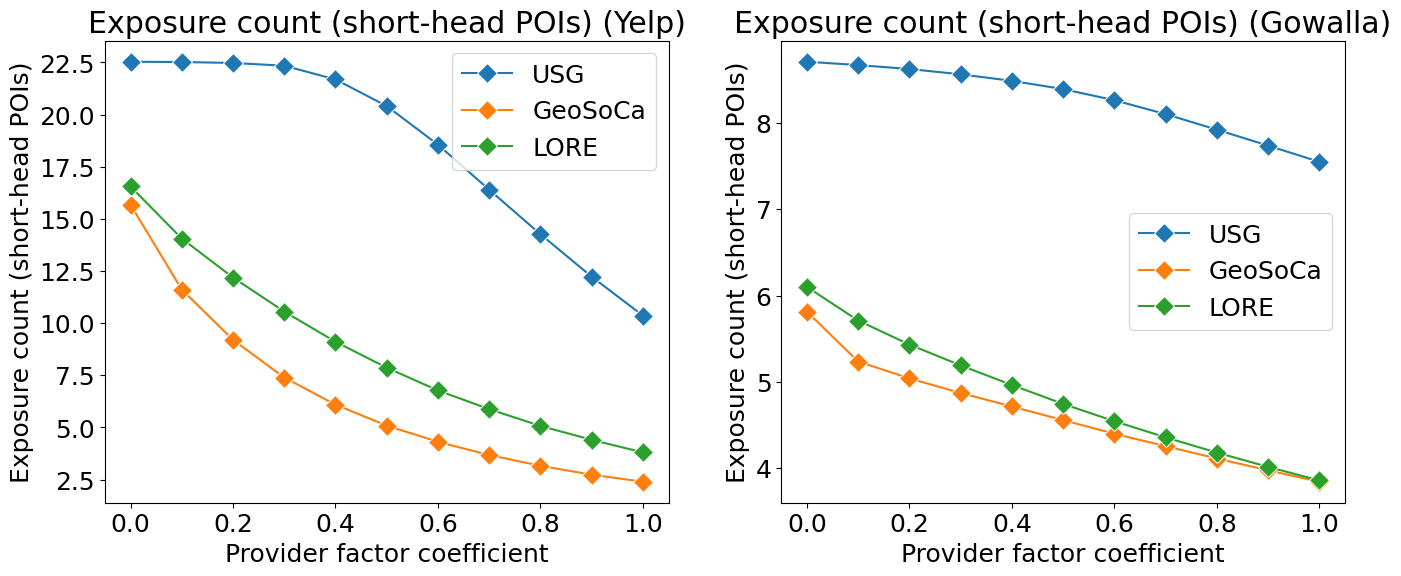

In [18]:
plot_provider_factor(df2, 'exposure_short_head')

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Median distance (Yelp)'}, xlabel='Provider factor coefficient', ylabel='Median distance'>,
        <Axes: title={'center': 'Median distance (Gowalla)'}, xlabel='Provider factor coefficient', ylabel='Median distance'>],
       dtype=object))

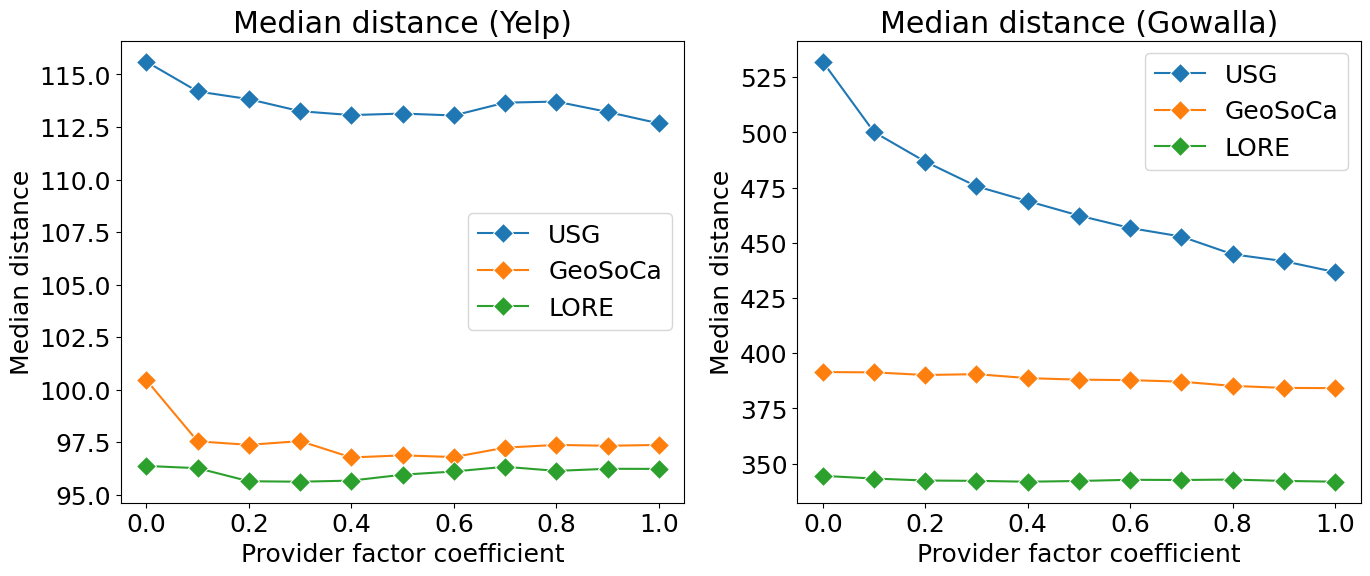

In [19]:
plot_provider_factor(df2, 'mean_median_distance')

## 3. Consumer Fairness Factor

In [20]:
def load_dataset_consumer_fairness(model_name, dataset, consumer_factor = 0):
    dataset_sizes = {
        'Yelp': 7135,
        'Gowalla': 5628
    }

    fairness = 'None'
    filename = f"../Outputs/LinearFairness/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.csv"
    if consumer_factor > 0:
        fairness = 'Consumer_beta' + str(consumer_factor)
        filename = f"../Outputs/3_ConsumerBeta/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.csv"

    return pd.read_csv(filename)

In [21]:
dataset_iter = product(
    ['USG', 'GeoSoCa', 'LORE'],
    ['Yelp', 'Gowalla'],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
)

_dfs = []

for model_name, dataset, consumer_factor in tqdm(dataset_iter, total=3*2*11):
    _df = load_dataset_consumer_fairness(model_name, dataset, consumer_factor)
    _df['model'] = model_name
    _df['dataset'] = dataset
    _df['consumer_coef'] = consumer_factor
    _dfs.append(_df)

df3 = pd.concat(_dfs)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 519.01it/s]


In [22]:
df3.head()

,precision,recall,ndcg,map,mean_median_distance,gce_users,precision_active_users,precision_inactive_users,gce_items,exposure_short_head,exposure_long_tail,model,dataset,consumer_coef
0,0.02968,0.04478,0.03981,0.01991,115.60542,-0.07079,0.05683,0.02290,-235.56310,22.53447,0.00773,USG,Yelp,0.0
0,0.02953,0.04449,0.03951,0.01972,115.53106,-0.07221,0.05683,0.02270,-314.24392,22.54206,0.00580,USG,Yelp,0.1
0,0.02928,0.04392,0.03921,0.01962,115.66074,-0.07458,0.05683,0.02239,-377.18858,22.54586,0.00483,USG,Yelp,0.2
0,0.02904,0.04341,0.03883,0.01947,115.60515,-0.07690,0.05683,0.02209,-443.83586,22.54870,0.00411,USG,Yelp,0.3
0,0.02890,0.04304,0.03855,0.01933,115.78599,-0.07830,0.05683,0.02192,-526.49916,22.55123,0.00346,USG,Yelp,0.4


In [23]:
df3[(df3.dataset == 'Yelp') & (df3.consumer_coef.isin([0, 1]))][['model', 'consumer_coef', 'precision']]

,model,consumer_coef,precision
0,USG,0.0,0.02968
0,USG,1.0,0.02804
0,GeoSoCa,0.0,0.02252
0,GeoSoCa,1.0,0.02562
0,LORE,0.0,0.02300
0,LORE,1.0,0.02657


In [159]:
def scatterplot_consumer_factor(df):
    _df = df[['precision_active_users', 'precision_inactive_users', 'model', 'dataset', 'consumer_coef']] \
            .rename(columns={'consumer_coef': 'Consumer weight', 'model': 'Model'})

    plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(data=_df[_df['dataset'] == 'Yelp'], x='precision_inactive_users', y='precision_active_users', style='Model', hue='Consumer weight', ax=axs[0])
    axs[0].get_legend().remove()
    axs[0].set_xlabel('Inctive Users')
    axs[0].set_ylabel('Active Users')
    axs[0].set_title(f'Precision (Yelp)')
    axs[0].plot([0.01, 0.02, 0.03], [0.01, 0.02, 0.03])
    # axs[0].set_xlim((-0.5, 10))
    # axs[0].set_ylim((-0.5, 25))
    sns.scatterplot(data=_df[_df['dataset'] == 'Gowalla'], x='precision_inactive_users', y='precision_active_users', style='Model', hue='Consumer weight', ax=axs[1])
    # axs[1].get_legend().remove()
    axs[1].set_xlabel('Inctive Users')
    axs[1].set_ylabel('Active Users')
    axs[1].set_title(f'Precision (Gowalla)')
    axs[1].plot([0.03, 0.04, 0.05], [0.03, 0.04, 0.05])
    # axs[1].set_xlim((-0.5, 4))
    # axs[1].set_ylim((-0.5, 10))
    axs[1].legend(bbox_to_anchor=(1.0, 0.6))

    fig.savefig(f"images_2/consumer_fairness_plot.png", bbox_inches='tight')
    return fig, axs

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Precision (Yelp)'}, xlabel='Inctive Users', ylabel='Active Users'>,
        <Axes: title={'center': 'Precision (Gowalla)'}, xlabel='Inctive Users', ylabel='Active Users'>],
       dtype=object))

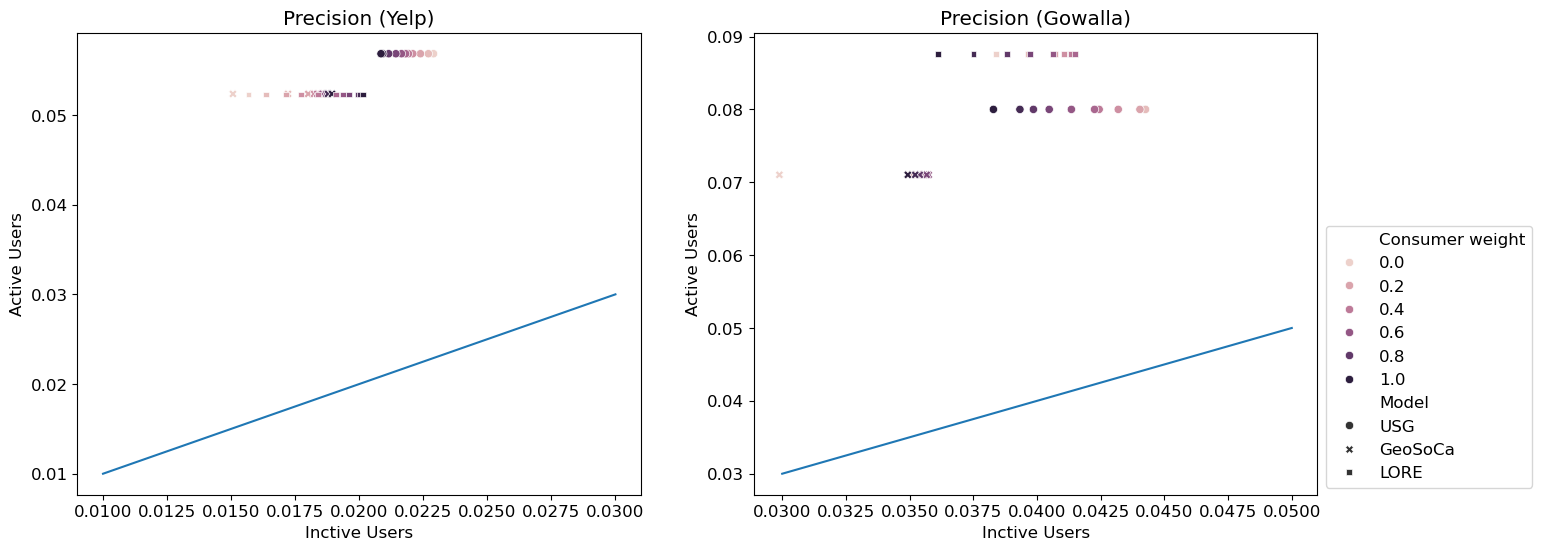

In [160]:
scatterplot_consumer_factor(df3)

In [25]:
def plot_consumer_factor(df, metric):
    _df = df[[metric, 'model', 'dataset', 'consumer_coef']]
    metric_name = METRIC_NAME_MAP[metric]

    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.lineplot(data=_df[_df['dataset'] == 'Yelp'], x='consumer_coef', y=metric, hue='model', marker='D', markersize=10.0, ax=axs[0])
    axs[0].legend()
    axs[0].set_xlabel('Consumer factor coefficient')
    axs[0].set_ylabel(metric_name)
    axs[0].set_title(f'{metric_name} (Yelp)')
    sns.lineplot(data=_df[_df['dataset'] == 'Gowalla'], x='consumer_coef', y=metric, hue='model', marker='D', markersize=10.0, ax=axs[1])
    axs[1].legend()
    axs[1].set_xlabel('Consumer factor coefficient')
    axs[1].set_ylabel(metric_name)
    axs[1].set_title(f'{metric_name} (Gowalla)')

    fig.savefig(f"images_3/{metric}_vs_consumer_beta.png", bbox_inches='tight')
    return fig, axs

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Precision@10 (Yelp)'}, xlabel='Consumer factor coefficient', ylabel='Precision@10'>,
        <Axes: title={'center': 'Precision@10 (Gowalla)'}, xlabel='Consumer factor coefficient', ylabel='Precision@10'>],
       dtype=object))

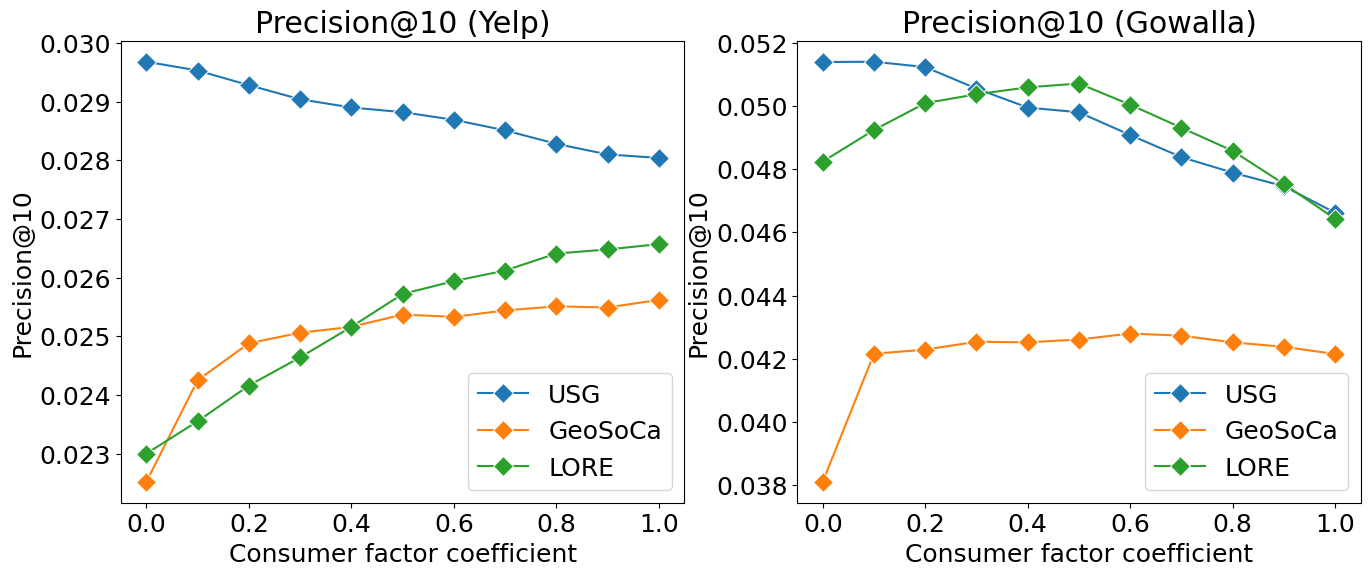

In [26]:
plot_consumer_factor(df3, 'precision')

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Precision@10 (inactive users) (Yelp)'}, xlabel='Consumer factor coefficient', ylabel='Precision@10 (inactive users)'>,
        <Axes: title={'center': 'Precision@10 (inactive users) (Gowalla)'}, xlabel='Consumer factor coefficient', ylabel='Precision@10 (inactive users)'>],
       dtype=object))

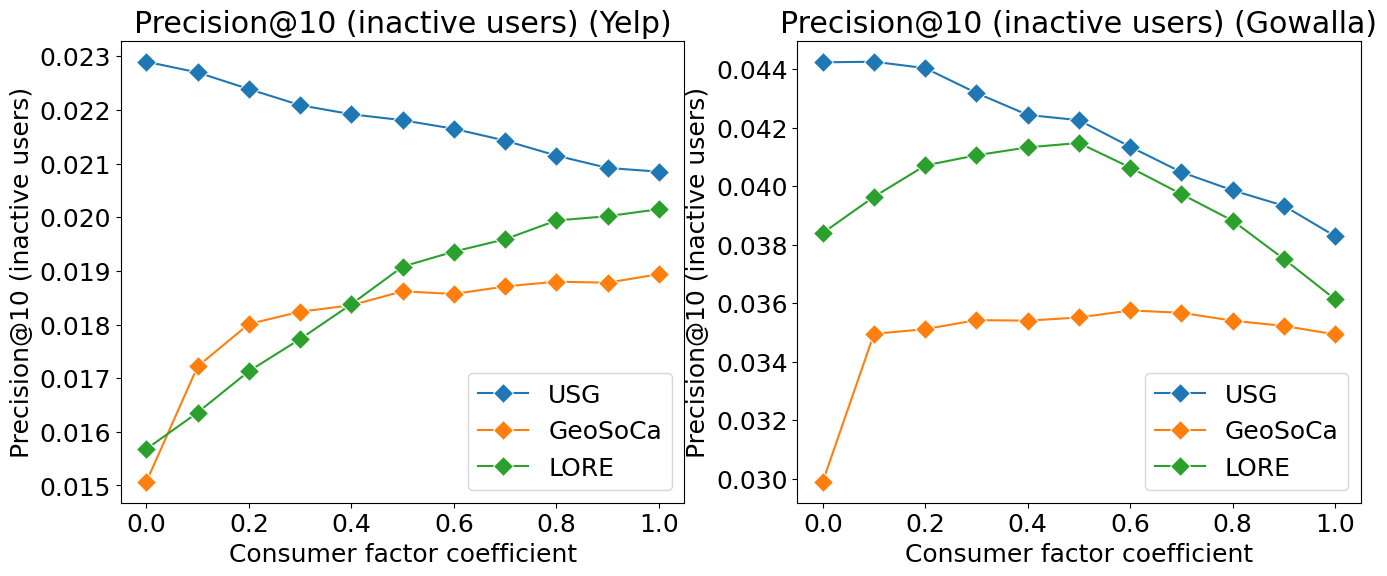

In [27]:
plot_consumer_factor(df3, 'precision_inactive_users')

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Median distance (Yelp)'}, xlabel='Consumer factor coefficient', ylabel='Median distance'>,
        <Axes: title={'center': 'Median distance (Gowalla)'}, xlabel='Consumer factor coefficient', ylabel='Median distance'>],
       dtype=object))

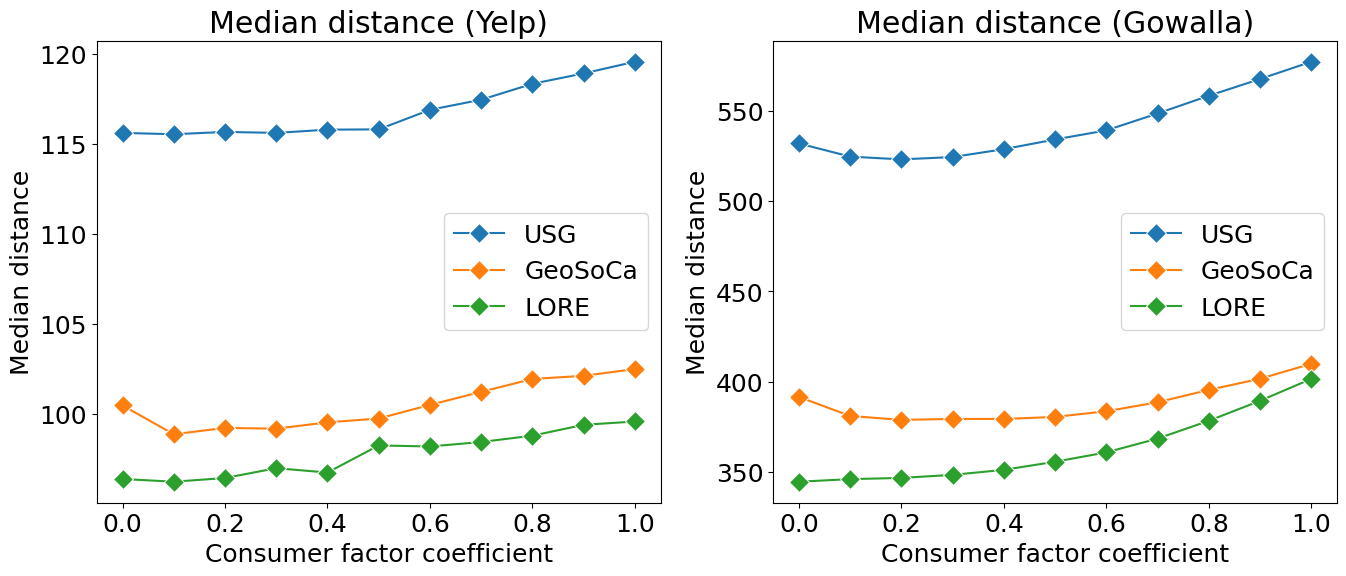

In [28]:
plot_consumer_factor(df3, 'mean_median_distance')

## 4. Tradeoff

In [29]:
def load_dataset_tradeoff(model_name, dataset, consumer_factor = 0):
    dataset_sizes = {
        'Yelp': 7135,
        'Gowalla': 5628
    }

    if consumer_factor == 0:
        fairness = 'Provider1.0'
        filename = f"../Outputs/LinearFairness/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.csv"
    elif consumer_factor == 1.0:
        fairness = 'Consumer_beta' + str(consumer_factor)
        filename = f"../Outputs/3_ConsumerBeta/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.csv"
    else:
        fairness = f'Both_LinearExposure_alpha{1-consumer_factor:.1f}_beta{consumer_factor:.1f}'
        filename = f"../Outputs/4_Tradeoff/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.csv"

    return pd.read_csv(filename)

In [30]:
dataset_iter = product(
    ['USG', 'GeoSoCa', 'LORE'],
    ['Yelp', 'Gowalla'],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
)

_dfs = []

for model_name, dataset, consumer_factor in tqdm(dataset_iter, total=3*2*11):
    _df = load_dataset_tradeoff(model_name, dataset, consumer_factor)
    _df['model'] = model_name
    _df['dataset'] = dataset
    _df['consumer_coef'] = consumer_factor
    _df['provider_coef'] = 1-consumer_factor
    _dfs.append(_df)

df4 = pd.concat(_dfs)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 462.28it/s]


In [31]:
df4.head()

,precision,recall,ndcg,map,mean_median_distance,gce_users,precision_active_users,precision_inactive_users,gce_items,exposure_short_head,exposure_long_tail,model,dataset,consumer_coef,provider_coef
0,0.01857,0.02972,0.02534,0.01231,112.67297,-0.04137,0.03118,0.01542,-0.13466,10.36022,3.07653,USG,Yelp,0.0,1.0
0,0.02045,0.03289,0.02794,0.01347,112.94778,-0.03697,0.03350,0.01719,-0.41302,14.40228,2.06880,USG,Yelp,0.1,0.9
0,0.02313,0.03707,0.03114,0.01497,113.23871,-0.03647,0.03777,0.01946,-1.07782,17.93422,1.17546,USG,Yelp,0.2,0.8
0,0.02456,0.03876,0.03279,0.01591,113.31184,-0.04282,0.04156,0.02030,-2.53813,20.17584,0.60509,USG,Yelp,0.3,0.7
0,0.02631,0.04065,0.03493,0.01714,113.19200,-0.05300,0.04681,0.02118,-5.45426,21.34756,0.30758,USG,Yelp,0.4,0.6


In [32]:
def plot_tradeoff(df, metric):
    _df = df[[metric, 'model', 'dataset', 'consumer_coef', 'provider_coef']]
    metric_name = METRIC_NAME_MAP[metric]

    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.lineplot(data=_df[_df['dataset'] == 'Yelp'], x='consumer_coef', y=metric, hue='model', marker='D', markersize=10.0, ax=axs[0])
    axs[0].legend()
    axs[0].set_xlabel('Consumer factor coefficient')
    axs[0].set_ylabel(metric_name)
    axs[0].set_title(f'{metric_name} (Yelp)')
    sns.lineplot(data=_df[_df['dataset'] == 'Gowalla'], x='consumer_coef', y=metric, hue='model', marker='D', markersize=10.0, ax=axs[1])
    axs[1].legend()
    axs[1].set_xlabel('Consumer factor coefficient')
    axs[1].set_ylabel(metric_name)
    axs[1].set_title(f'{metric_name} (Gowalla)')

    fig.savefig(f"images_4/{metric}_vs_tradeoff.png", bbox_inches='tight')
    return fig, axs

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Precision@10 (Yelp)'}, xlabel='Consumer factor coefficient', ylabel='Precision@10'>,
        <Axes: title={'center': 'Precision@10 (Gowalla)'}, xlabel='Consumer factor coefficient', ylabel='Precision@10'>],
       dtype=object))

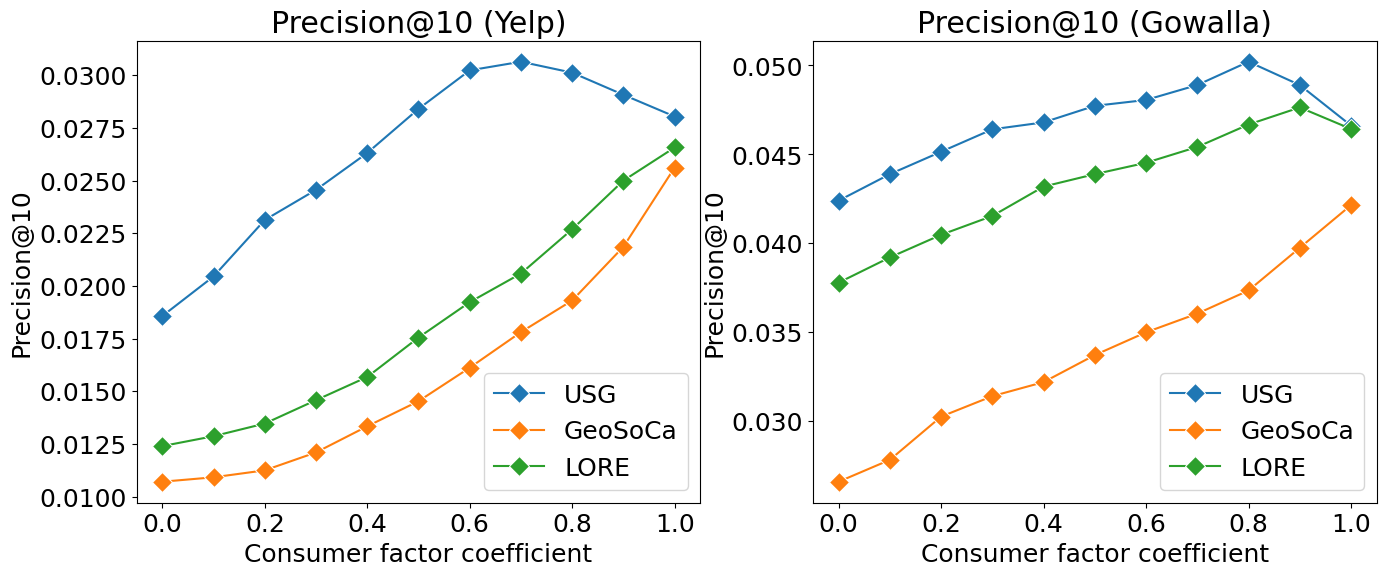

In [33]:
plot_tradeoff(df4, 'precision')

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Precision@10 (inactive users) (Yelp)'}, xlabel='Consumer factor coefficient', ylabel='Precision@10 (inactive users)'>,
        <Axes: title={'center': 'Precision@10 (inactive users) (Gowalla)'}, xlabel='Consumer factor coefficient', ylabel='Precision@10 (inactive users)'>],
       dtype=object))

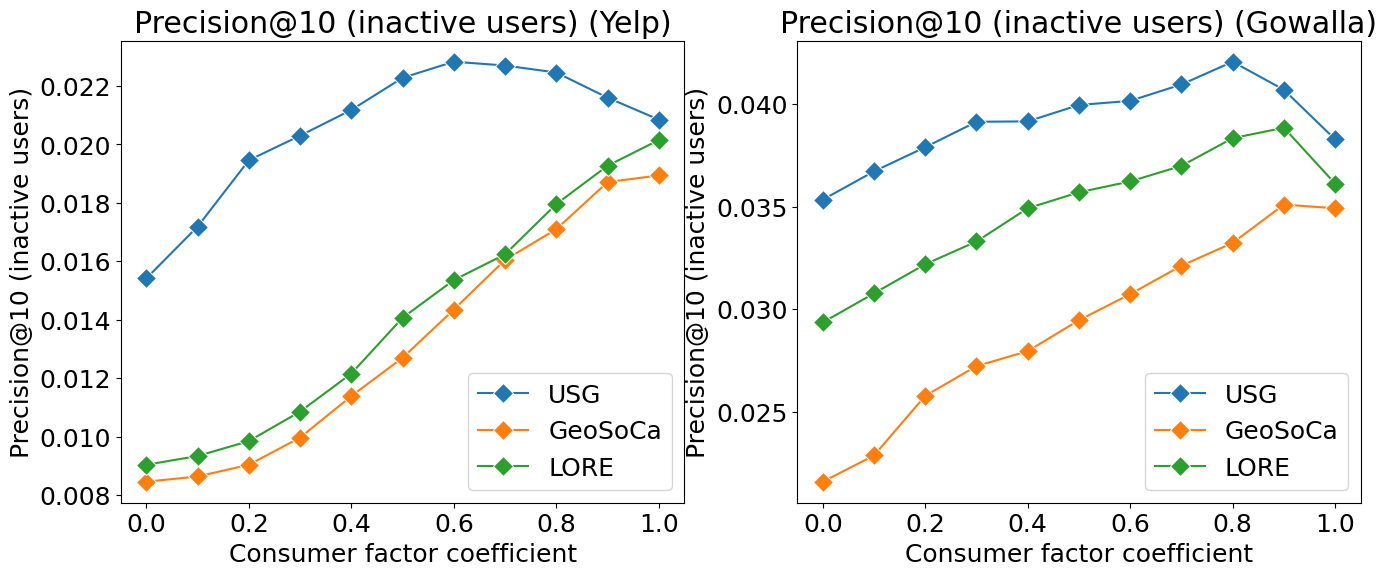

In [34]:
plot_tradeoff(df4, 'precision_inactive_users')

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Exposure count (long-tail POIs) (Yelp)'}, xlabel='Consumer factor coefficient', ylabel='Exposure count (long-tail POIs)'>,
        <Axes: title={'center': 'Exposure count (long-tail POIs) (Gowalla)'}, xlabel='Consumer factor coefficient', ylabel='Exposure count (long-tail POIs)'>],
       dtype=object))

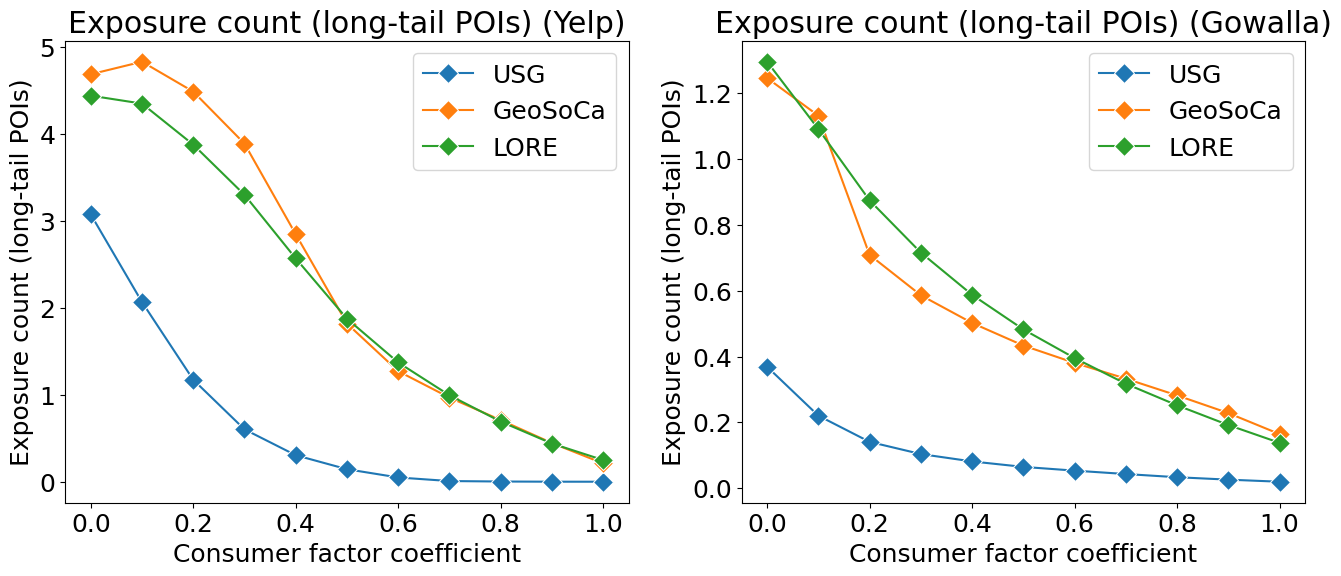

In [35]:
plot_tradeoff(df4, 'exposure_long_tail')

## 5. Tradeoff v2

In [36]:
def load_dataset_tradeoff_v2(model_name, dataset, k = 10, weights = (0, 0)):
    dataset_sizes = {
        'Yelp': 7135,
        'Gowalla': 5628
    }

    fairness = 'None'
    filename = f"../Outputs/5_Tradeoff_Table/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.csv"

    if k == 10:
        if weights == (0, 0):
            fairness = 'None'
            filename = f"../Outputs/5_Tradeoff_Table/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.csv"
        elif weights[0] == 0:
            fairness = 'Consumer_beta' + str(weights[1])
            filename = f"../Outputs/5_Tradeoff_Table/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.csv"
        elif weights[1] == 0:
            fairness = 'Provider' + str(weights[0])
            filename = f"../Outputs/5_Tradeoff_Table/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.csv"
        else:
            fairness = f'Both_LinearExposure_alpha{weights[0]}_beta{weights[1]}'
            filename = f"../Outputs/5_Tradeoff_Table/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.csv"
    else:
        if weights == (0, 0):
            fairness = 'None'
        elif weights[0] == 0:
            fairness = 'Consumer_beta' + str(weights[1])
        elif weights[1] == 0:
            fairness = 'Provider_LinearExposure_alpha' + str(weights[0])
        else:
            fairness = f'Both_LinearExposure_alpha{weights[0]}_beta{weights[1]}'
        filename = f"../Outputs/5_Tradeoff_Table/Eval_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top{k}_limit30.csv"

    return pd.read_csv(filename)

In [37]:
dataset_iter = product(
    ['USG', 'GeoSoCa', 'LORE'],
    ['Yelp', 'Gowalla'],
    [5, 10, 20],
    [
        (0, 0),
        (0.5, 0),
        (0.25, 0.25),
        (0, 0.5),
        (1.0, 0),
        (0.5, 0.5),
        (0, 1.0),
    ],
)

_dfs = []

for model_name, dataset, k, weights in tqdm(dataset_iter, total=3*2*7*3):
    _df = load_dataset_tradeoff_v2(model_name, dataset, k, weights)
    _df['model'] = model_name
    _df['dataset'] = dataset
    _df['k'] = k
    _df['provider_coef'] = weights[0]
    _df['consumer_coef'] = weights[1]
    _dfs.append(_df)

df5 = pd.concat(_dfs)

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 342.93it/s]


In [38]:
df5_yelp = df5[df5.dataset == 'Yelp'][['model', 'k', 'provider_coef', 'consumer_coef', 'precision', 'gce_items', 'gce_users', 'mean_median_distance']]

df5_yelp.head()

,model,k,provider_coef,consumer_coef,precision,gce_items,gce_users,mean_median_distance
0,USG,5,0.00,0.00,0.03397,-404.16486,-0.05906,115.49726
0,USG,5,0.50,0.00,0.03083,-3.26253,-0.05556,112.54663
0,USG,5,0.25,0.25,0.03518,-182.26320,-0.05818,112.82197
0,USG,5,0.00,0.50,0.03324,-595.83844,-0.06434,117.46961
0,USG,5,1.00,0.00,0.02094,-0.16983,-0.02918,112.63371


In [39]:
df5_yelp_table = df5_yelp.pivot(index=['model', 'provider_coef', 'consumer_coef'], columns=['k']).reset_index()

In [45]:
def generate_latex_table_v2(table):
    template = """
        \\begin{tabular}{|c c||c c c|c c c|c c c|c c c|}
            \hline
            Model & Fairness Weights & \multicolumn{3}{c|}{Precision} & \multicolumn{3}{c|}{Item fairness GCE} & \multicolumn{3}{c|}{User fairness GCE} & \multicolumn{3}{c|}{Mean median distance} \\\\
            & $(\\alpha, \\beta)$ & @5 & @10 & @20 & @5 & @10 & @20 & @5 & @10 & @20 & @5 & @10 & @20 \\\\
            \hline\hline
            """ + "\n".join([
                (f"{row['model'].iloc[0]} & {(row['provider_coef'].iloc[0], row['consumer_coef'].iloc[0])}"
                 + f" & {row['precision'][5]} & {row['precision'][10]} & {row['precision'][20]}"
                 + f" & {row['gce_items'][5]} & {row['gce_items'][10]} & {row['gce_items'][20]}"
                 + f" & {row['gce_users'][5]} & {row['gce_users'][10]} & {row['gce_users'][20]}"
                 + f" & {row['mean_median_distance'][5]} & {row['mean_median_distance'][10]} & {row['mean_median_distance'][20]}"
                 + " \\\\")
                for _, row in table.iterrows()
            ]) + """
            \hline
        \\end{tabular}
    """
    return template

In [47]:
print(generate_latex_table_v2(df5_yelp_table))


        \begin{tabular}{|c c||c c c|c c c|c c c|c c c|}
            \hline
            Model & Fairness Weights & \multicolumn{3}{c|}{Precision} & \multicolumn{3}{c|}{Item fairness GCE} & \multicolumn{3}{c|}{User fairness GCE} & \multicolumn{3}{c|}{Mean median distance} \\
            & $(\alpha, \beta)$ & @5 & @10 & @20 & @5 & @10 & @20 & @5 & @10 & @20 & @5 & @10 & @20 \\
            \hline\hline
            GeoSoCa & (0.0, 0.0) & 0.02537 & 0.02252 & 0.01901 & -0.67755 & -0.59265 & -0.5093 & -0.14592 & -0.14098 & -0.14513 & 101.17249 & 100.45895 & 99.29816 \\
GeoSoCa & (0.0, 0.5) & 0.0291 & 0.02537 & 0.02159 & -5.89764 & -4.54826 & -3.34275 & -0.09071 & -0.09333 & -0.09345 & 100.33198 & 99.73246 & 99.80617 \\
GeoSoCa & (0.0, 1.0) & 0.02949 & 0.02562 & 0.02195 & -9.9195 & -8.07117 & -6.32284 & -0.08641 & -0.09007 & -0.08808 & 102.35795 & 102.48056 & 101.51285 \\
GeoSoCa & (0.25, 0.25) & 0.0169 & 0.01598 & 0.01399 & -0.6379 & -0.56611 & -0.49125 & -0.04459 & -0.03675 & -0.04917 & 98.6

In [40]:
df5_yelp['gce_items_exp'] = np.exp(df5_yelp['gce_items'])
df5_yelp['gce_users_exp'] = np.exp(df5_yelp['gce_users'])

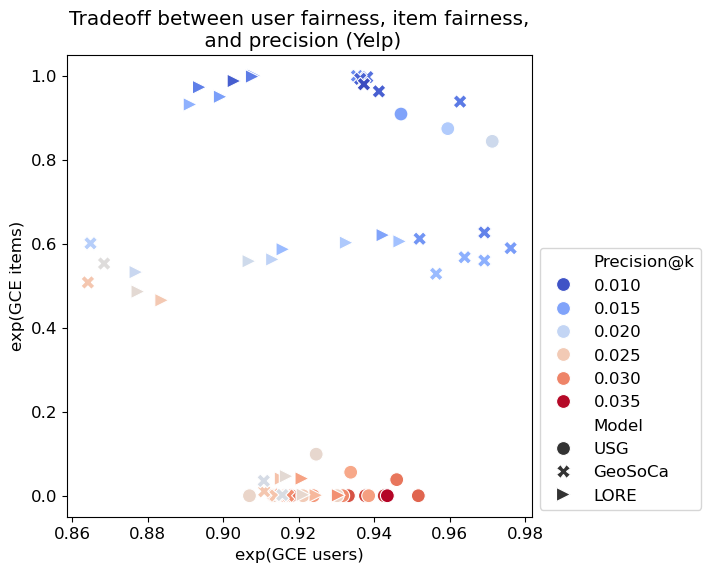

In [54]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(6,6))
# sns.scatterplot(data=df5_yelp.rename(columns={'precision': 'Precision@k'}), x='gce_users_exp', y='gce_items_exp', hue='Precision@k', palette='Spectral', style='k', ax=ax)
sns.scatterplot(data=df5_yelp.rename(columns={'precision': 'Precision@k', 'model': 'Model'}),
                x='gce_users_exp', y='gce_items_exp', hue='Precision@k',
                palette='coolwarm', style='Model',
                s=100.0, markers=['o', 'X', '>'],
                ax=ax)

ax.set_xlabel('exp(GCE users)')
ax.set_ylabel('exp(GCE items)')
ax.set_title(f'Tradeoff between user fairness, item fairness,\n and precision (Yelp)')
ax.legend(bbox_to_anchor=(1.0, 0.6))
fig.savefig(f"tradeoff_scatter_yelp.png", bbox_inches='tight')

In [55]:
df5_gowalla = df5[df5.dataset == 'Gowalla'][['model', 'k', 'provider_coef', 'consumer_coef', 'precision', 'gce_items', 'gce_users', 'mean_median_distance']]

df5_gowalla['gce_items_exp'] = np.exp(df5_gowalla['gce_items'])
df5_gowalla['gce_users_exp'] = np.exp(df5_gowalla['gce_users'])


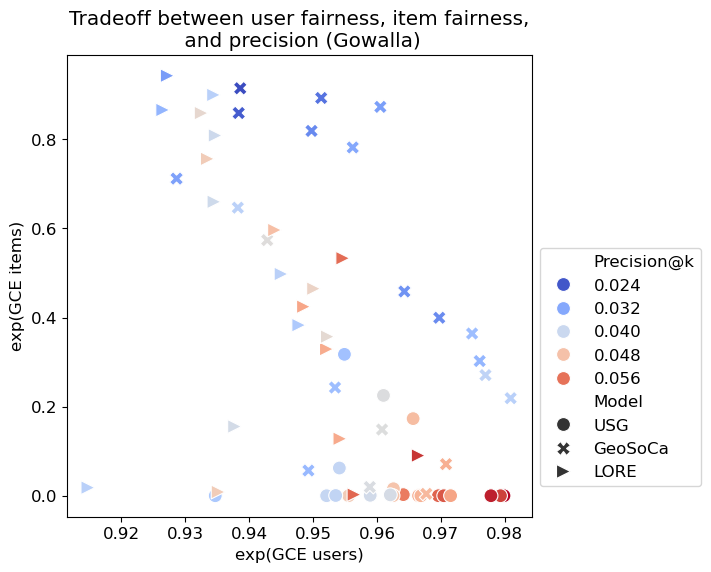

In [56]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(6,6))
# sns.scatterplot(data=df5_gowalla.rename(columns={'precision': 'Precision@k'}), x='gce_users_exp', y='gce_items_exp', hue='Precision@k', palette='Spectral', style='k', ax=ax)
sns.scatterplot(data=df5_gowalla.rename(columns={'precision': 'Precision@k', 'model': 'Model'}),
                x='gce_users_exp', y='gce_items_exp', hue='Precision@k',
                palette='coolwarm', style='Model',
                s=100.0, markers=['o', 'X', '>'], ax=ax)

ax.set_xlabel('exp(GCE users)')
ax.set_ylabel('exp(GCE items)')
ax.set_title(f'Tradeoff between user fairness, item fairness,\n and precision (Gowalla)')
ax.legend(bbox_to_anchor=(1.0, 0.6))
fig.savefig(f"tradeoff_scatter_gowalla.png", bbox_inches='tight')